# Comparing SWAT-derived vs HALAMA (Penumbra) surface and soil temperature models

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
import tempfile
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from natsort import natsorted
import os
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.font_manager import FontProperties
import seaborn as sns
# import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
from functools import reduce

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 140

In [3]:
# Import and format observed data (2003-2007 runoff)

input_dir = config.velma_data
results_dir = config.data_path.parents[0] / 'results' / 'calibration'
sims = ['ellsworth_baseline_03_07_21', 'ellsworth_baseline_03_07_24']

runoff_start = pd.to_datetime('01-01-2003')
runoff_end = pd.to_datetime('12-31-2007')
nse_start = pd.to_datetime('01-01-2004')
nse_end = pd.to_datetime('12-31-2007')

start = pd.to_datetime('01-01-2004')
end = pd.to_datetime('12-31-2007')

# Import VELMA outputs

results = []
for sim in sims:
    sim_dir = results_dir / sim
    velma_results = pd.read_csv(sim_dir / 'DailyResults.csv')
    
    # Format datetime of results
    jday_pad = velma_results['Day'].apply(lambda x: str(x).zfill(3))
    str_year = velma_results['Year'].apply(lambda x: str(x))
    velma_results['year_jday'] = str_year + jday_pad
    velma_results.index = pd.to_datetime(velma_results['year_jday'], format='%Y%j')
    velma_results = velma_results[(velma_results.index >= start) & (velma_results.index <= end)]
    results.append(velma_results)

swat_results = results[0]
halama_results = results[1]

# Stream temperature observations
streamtemp_path = config.data_path / 'hydrology' / 'ellsworth' / 'wa_ecy_gauge' / 'stream_temp' / 'ells_streamtemp_2003_2008.csv'
streamtemp_obs = pd.read_csv(streamtemp_path, usecols=['date', 'water_temp'], parse_dates=True, index_col=0)
streamtemp_obs['doy'], streamtemp_obs['year'] = streamtemp_obs.index.dayofyear, streamtemp_obs.index.year
streamtemp_obs = streamtemp_obs[(streamtemp_obs.index >= start) & (streamtemp_obs.index <= end)]

# Stream temperature quality codes
streamtemp_path = config.data_path  / 'hydrology' / 'ellsworth' / 'wa_ecy_gauge' / 'stream_temp' / 'ells_streamtemp_2003_2008.csv'
stream_temp_quality = pd.read_csv(streamtemp_path, usecols=['date', 'quality'], parse_dates=True, index_col=0)
stream_temp_quality['doy'], stream_temp_quality['year'] = stream_temp_quality.index.dayofyear, stream_temp_quality.index.year
stream_temp_quality = stream_temp_quality[(stream_temp_quality.index >= start) & (stream_temp_quality.index <= end)]

# Runoff observations
runoff_path = input_dir / 'runoff' / 'ellsworth_Q_2003_2007_dummy.csv'
runoff_obs = pd.read_csv(runoff_path, names=['runoff_obs'])
runoff_obs.index = pd.date_range(runoff_start, runoff_end)
runoff_obs['doy'], runoff_obs['year'] = runoff_obs.index.dayofyear, runoff_obs.index.year
runoff_obs = runoff_obs[(runoff_obs.index >= start) & (runoff_obs.index <= end)]

# Runoff quality codes
flow_path = config.streamflow
quality = pd.read_csv(flow_path, usecols=['Date', 'Quality'], parse_dates=True, index_col=0)
quality = quality[(quality.index >= start) & (quality.index <= end)]

# Precipitation
precip_path = input_dir / 'precip' / 'PRISM_gauge_avg_ppt_2003_2019.csv'
forcing_start = pd.to_datetime('01-01-2003')
forcing_end = pd.to_datetime('12-31-2019')                     
precip = pd.read_csv(precip_path, names=['precip'])
precip.index = pd.date_range(forcing_start, forcing_end)
precip['doy'], precip['year'] = precip.index.dayofyear, precip.index.year
precip = precip[(precip.index >= start) & (precip.index <= end)]

# Air temperature
temp_path = input_dir / 'temp' / 'ellsworth_temp_2003_2019.csv'
temp = pd.read_csv(temp_path, names=['temp'])
temp.index = pd.date_range(forcing_start, forcing_end)
temp['doy'], temp['year'] = temp.index.dayofyear, temp.index.year
temp = temp[(temp.index >= start) & (temp.index <= end)]

In [4]:
# Get stream temperature from cell writer files

# Get paths
all_cell_results = []
for sim in sims:
    cell_paths = []
    for file in os.listdir(results_dir / sim):
        if file.startswith('Cell_'):
            cell_paths.append(file)

    nodes = []
    for path in cell_paths:
        nodes.append(path.split('_')[-1])

    cell_paths_sorted = [x for _,x in natsorted(zip(nodes, cell_paths))]

    cell_results = []
    for path in cell_paths_sorted:
        cell_result = pd.read_csv(results_dir / sim / path)
        jday_pad = cell_result['Jday'].apply(lambda x: str(x).zfill(3))
        str_year = cell_result['Year'].apply(lambda x: str(x))
        cell_result['date'] = str_year + jday_pad
        rng = pd.to_datetime(cell_result['date'], format='%Y%j')
        cell_result.index = rng
        cell_result = cell_result[(cell_result.index >= start) & (cell_result.index <= end)]
        cell_results.append(cell_result)

    all_cell_results.append(cell_results)


In [5]:
# Convert to pivot tables

outlet_pivots = []
for sim in all_cell_results:
    piv = pd.pivot_table(sim[0], index=['Jday'], columns=['Year'], 
                         values='Water_Surface_Temperature(degrees_C)', dropna=False)
    outlet_pivots.append(piv)

streamtemp_obs_yearly = pd.pivot_table(streamtemp_obs, index=['doy'], columns=['year'],
                                   values='water_temp', dropna=False)

runoff_swat_yearly = pd.pivot_table(swat_results, index=['Day'], columns=['Year'],
                                   values='Runoff_All(mm/day)_Delineated_Average', dropna=False)

runoff_halama_yearly = pd.pivot_table(halama_results, index=['Day'], columns=['Year'],
                                   values='Runoff_All(mm/day)_Delineated_Average', dropna=False)

runoff_obs_yearly = pd.pivot_table(runoff_obs, index=['doy'], columns=['year'],
                                   values='runoff_obs', dropna=False)

streamtemp_swat_yearly = outlet_pivots[0]
streamtemp_halama_yearly = outlet_pivots[1] 

## Plotting

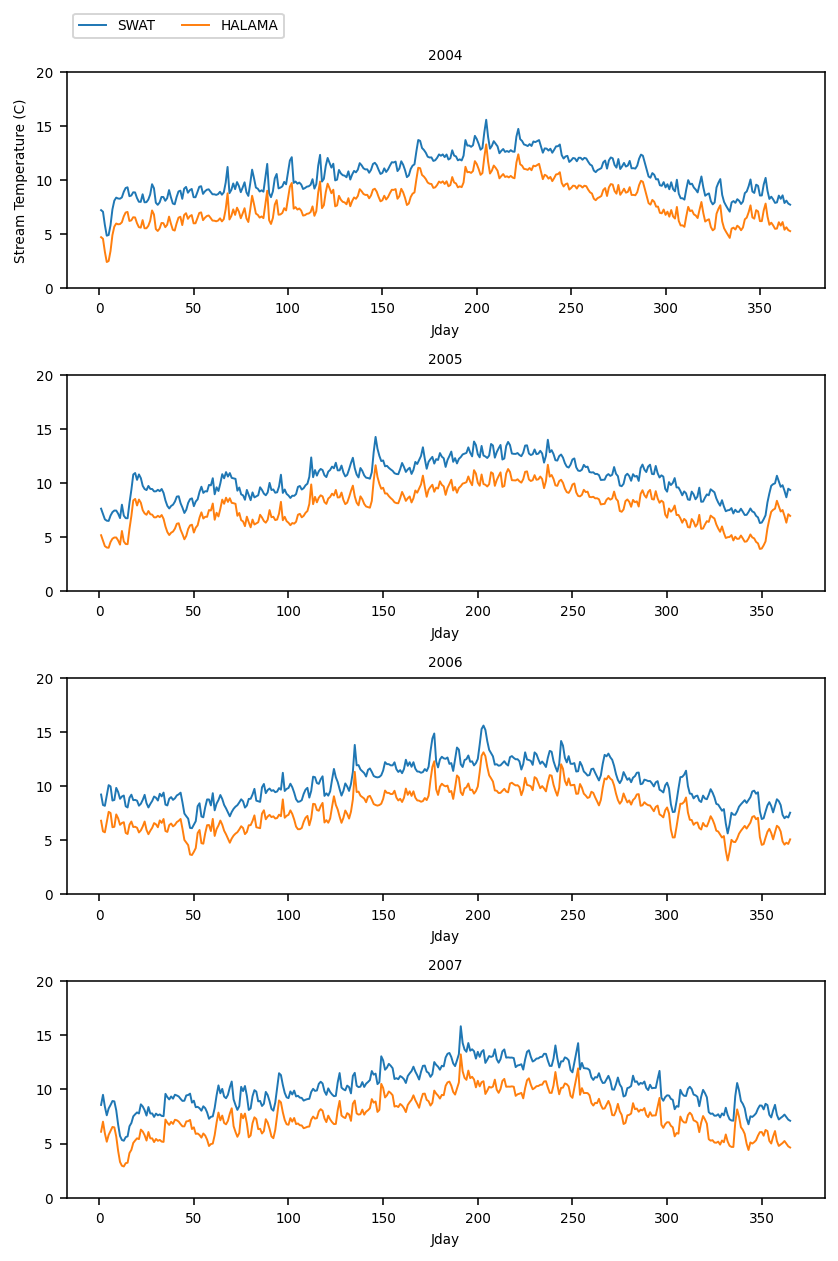

In [6]:
# Observed vs. simulated stream temp for gauge
years = streamtemp_obs_yearly.columns.get_level_values(0)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    streamtemp_swat_yearly.iloc[:, col].plot(ax=axes[col], label='SWAT', linewidth=1)
    streamtemp_halama_yearly.iloc[:, col].plot(ax=axes[col], label='HALAMA', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 20])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Stream Temperature (C)')
plt.tight_layout()

The HALAMA soil temperature model predicts the same pattern of stream temperature, but about 22% less